In [ ]:
filename = "../data/SPARCS_2024_simplified.csv"
TRAIN_SIZE = 0.8
SEED = 42
desired_transformation = 'Box-Cox Transform'  # CHANGE this to select different transformations



In [ ]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.pipeline import Pipeline

from scipy import stats
from sklearn.preprocessing import PowerTransformer
from scipy.stats import rankdata, norm

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
np.random.seed(SEED)

def preprocessing(df):
    df.columns = df.columns.str.replace(r"[^0-9a-zA-Z]+", " ", regex=True) \
                            .str.title() \
                            .str.replace(" ", "", regex=False) # Columns to CamelCase with no spaces
    df.drop(df[df["LengthOfStay"] == "120+"].index, inplace=True) # Remove for now (capping would introduce bias)
    for col in ["LengthOfStay", "BirthWeight", "TotalCharges", "TotalCosts"]:
        df[col] = pd.to_numeric(df[col], errors='coerce') # Convert to numeric, setting errors to NaN
    cat_cols = df.select_dtypes(include=str).columns # Transform the rest to categories
    for c in cat_cols:
        df[c] = df[c].astype("category")
    return df
def list_of_repeated_cols(df):
    def maps_to_single(df, col1, col2, dropna=False):
        s = df.groupby(col1, dropna=not dropna)[col2].nunique(dropna=dropna)
        return s.max() == 1
    
    cats = df.select_dtypes(include="category").columns

    one_to_one = []
    for col1 in cats:
        for col2 in cats:
            if col1 >= col2:  # prevents duplicates, keeps unordered pairs once
                continue
            if maps_to_single(df, col1, col2) and maps_to_single(df, col2, col1):
                one_to_one.append((col1, col2))
    return one_to_one



In [ ]:
df = pd.read_csv(filename,dtype=str)
df = preprocessing(df)

# Dropping columns
equivalent_pairs = list_of_repeated_cols(df)
print("Columns with one-to-one mappings: ", equivalent_pairs)
df = df.drop(columns=[pair[1] for pair in equivalent_pairs]) # Drop diagnosis, procedure, APR DRG, APR MDC, and AprSeverityOfIllness descriptions, and keep its codes
df = df.drop(columns=["FacilityName"]) # FacilityName is also represented in PermanentFacilityId
df = df.drop(columns=["TotalCharges", "TotalCosts"]) # 

# Ordinal Categorical Variables
age_order = ['0-17', '18-29', '30-49', '50-69', '70 or Older']
age_cat_type = CategoricalDtype(categories=age_order, ordered=True)
df['AgeGroup'] = df['AgeGroup'].astype(age_cat_type)

# Additional Supporting Variables
df["is_surgical"] = (df["AprMedicalSurgicalDescription"] == "Surgical").astype(int)
df["high_severity"] = df["AprSeverityOfIllnessCode"].isin(["3", "4"]).astype(int)
df["is_emergency"] = (df["EmergencyDepartmentIndicator"] == "Y").astype(int)
df["is_elective"] = (df["TypeOfAdmission"] == "Elective").astype(int)
df["discharged_home"] = df["PatientDisposition"].str.contains("Home", na=False).astype(int)
df["is_elderly"] = df["AgeGroup"].isin(["70 or Older"]).astype(int)

# Log Transform LOS. TODO: Try other transformations
# df["LengthOfStay"] = np.log1p(df["LengthOfStay"]) # NOTE: PREDICTION HAS TO BE TRANSFORMED BACK

df.sample(5)

Columns with one-to-one mappings:  [('CcsrDiagnosisCode', 'CcsrDiagnosisDescription'), ('CcsrProcedureCode', 'CcsrProcedureDescription'), ('AprDrgCode', 'AprDrgDescription'), ('AprMdcCode', 'AprMdcDescription'), ('AprSeverityOfIllnessCode', 'AprSeverityOfIllnessDescription')]


,HealthServiceArea,HospitalCounty,OperatingCertificateNumber,PermanentFacilityId,AgeGroup,ZipCode,Gender,Race,Ethnicity,LengthOfStay,TypeOfAdmission,PatientDisposition,DischargeYear,CcsrDiagnosisCode,CcsrProcedureCode,AprDrgCode,AprMdcCode,AprSeverityOfIllnessCode,AprRiskOfMortality,AprMedicalSurgicalDescription,PaymentTypology1,PaymentTypology2,PaymentTypology3,BirthWeight,EmergencyDepartmentIndicator,is_surgical,high_severity,is_emergency,is_elective,discharged_home,is_elderly
42433,Southern Tier,Broome,303001.0,42.0,70 or Older,139,M,White,Not Span/Hispanic,16,Emergency,Home or Self Care,2024,INF012,ESA004,137,4,4,Extreme,Medical,Medicare,NaN,NaN,NaN,Y,0,1,1,0,1,1
93000,New York City,New York,7002020.0,1453.0,70 or Older,115,M,White,Not Span/Hispanic,4,Elective,Home or Self Care,2024,NEO002,LYM003,91,3,1,Minor,Surgical,Medicare,NaN,NaN,NaN,N,1,0,0,1,1,1
17736,New York City,Bronx,7000002.0,1165.0,50-69,104,M,Black/African American,Unknown,1,Emergency,Left Against Medical Advice,2024,DIG020,NaN,282,7,2,Minor,Medical,Medicaid,NaN,NaN,NaN,Y,0,0,1,0,0,0
200517,Western NY,Erie,1401008.0,213.0,70 or Older,142,F,Other Race,Spanish/Hispanic,3,Emergency,Home or Self Care,2024,CIR017,NaN,201,5,2,Major,Medical,Medicare,NaN,NaN,NaN,Y,0,0,1,0,1,1
170417,New York City,Queens,7003004.0,1630.0,70 or Older,110,F,White,Not Span/Hispanic,4,Emergency,Home w/ Home Health Services,2024,DIG025,GIS016,253,6,2,Moderate,Medical,Medicare,Medicare,Self-Pay,NaN,Y,0,0,1,0,1,1


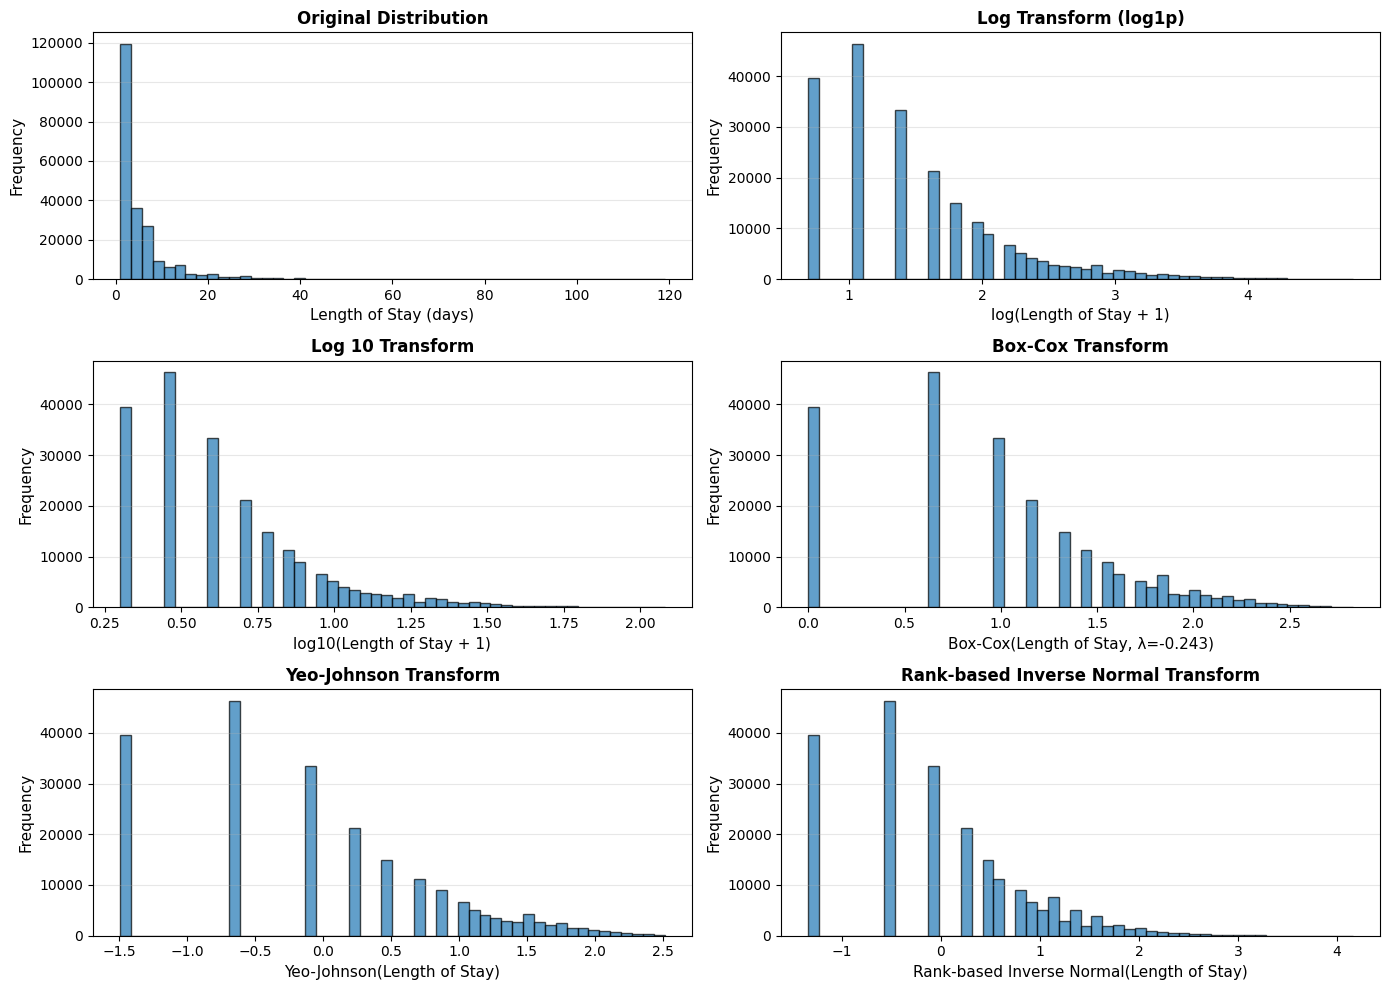

In [ ]:
# Histogram for the most common transformations
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Original
axes[0, 0].hist(df["LengthOfStay"], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Length of Stay (days)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Original Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Log Transform
axes[0, 1].hist(np.log1p(df["LengthOfStay"]), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('log(Length of Stay + 1)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Log Transform (log1p)', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Log 10 Transform
axes[1, 0].hist(np.log10(df["LengthOfStay"] + 1), bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('log10(Length of Stay + 1)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Log 10 Transform', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Box-Cox Transform
los_boxcox, lambda_param = stats.boxcox(df["LengthOfStay"])
axes[1, 1].hist(los_boxcox, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel(f'Box-Cox(Length of Stay, λ={lambda_param:.3f})', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Box-Cox Transform', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# Yeo-Johnson Transform
pt = PowerTransformer(method='yeo-johnson')
los_yeojohnson = pt.fit_transform(df[["LengthOfStay"]]).flatten()
axes[2, 0].hist(los_yeojohnson, bins=50, edgecolor='black', alpha=0.7)
axes[2, 0].set_xlabel('Yeo-Johnson(Length of Stay)', fontsize=11)
axes[2, 0].set_ylabel('Frequency', fontsize=11)
axes[2, 0].set_title('Yeo-Johnson Transform', fontsize=12, fontweight='bold')
axes[2, 0].grid(axis='y', alpha=0.3)

# Rank-based inverse normal transform
los_rank = rankdata(df["LengthOfStay"], method='average')
los_ranknorm = norm.ppf(los_rank / (len(df["LengthOfStay"]) + 1))
axes[2, 1].hist(los_ranknorm, bins=50, edgecolor='black', alpha=0.7)
axes[2, 1].set_xlabel('Rank-based Inverse Normal(Length of Stay)', fontsize=11)
axes[2, 1].set_ylabel('Frequency', fontsize=11)
axes[2, 1].set_title('Rank-based Inverse Normal Transform', fontsize=12, fontweight='bold')
axes[2, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# OUTPUT VARIABLE TRANSFORMATION
with_transformed_los = True
if desired_transformation == 'Log Transform':
    transf_function = lambda x: np.log1p(x)
    backtransf_function = lambda x: np.expm1(x)  # Inverse transformation
elif desired_transformation == 'Log 10 Transform':
    transf_function = lambda x: np.log10(x + 1)
    backtransf_function = lambda x: 10**x - 1  # Inverse transformation
elif desired_transformation == 'Box-Cox Transform':
    lambda_param = stats.boxcox_normmax(df["LengthOfStay"])
    transf_function = lambda x: stats.boxcox(x, lmbda=lambda_param)
    backtransf_function = lambda x: stats.inv_boxcox(x, lmbda=lambda_param)  # Inverse transformation
elif desired_transformation == 'Yeo-Johnson Transform':
    pt = PowerTransformer(method='yeo-johnson')
    transf_function = lambda x: pt.fit_transform(x.values.reshape(-1, 1)).flatten()
    backtransf_function = lambda x: pt.inverse_transform(x.values.reshape(-1, 1)).flatten()  # Inverse transformation
elif desired_transformation == 'Rank-based Inverse Normal Transform':
    transf_function = lambda x: norm.ppf(rankdata(x, method='average') / (len(x) + 1))
    backtransf_function = None  # Inverse transformation is not straightforward
else:
    desired_transformation = 'None'
    transf_function = lambda x: x  # No transformation
    backtransf_function = lambda x: x  # No transformation
    with_transformed_los = False

df["Transformed_LengthOfStay"] = transf_function(df["LengthOfStay"]) # NOTE: PREDICTION HAS TO BE TRANSFORMED BACK


In [ ]:
# High Cardinality Categorical Variables
d = {}
categoric_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categoric_cols:
    d[col] = df[col].nunique(dropna=True)
num_uniquecats_df = pd.DataFrame.from_dict(d, orient='index', columns=['Unique Values'])
num_uniquecats_df.sort_values(by='Unique Values', ascending=False)


,Unique Values
CcsrDiagnosisCode,453
AprDrgCode,336
CcsrProcedureCode,316
PermanentFacilityId,205
OperatingCertificateNumber,158
HospitalCounty,57
ZipCode,50
AprMdcCode,26
PatientDisposition,19
PaymentTypology3,9


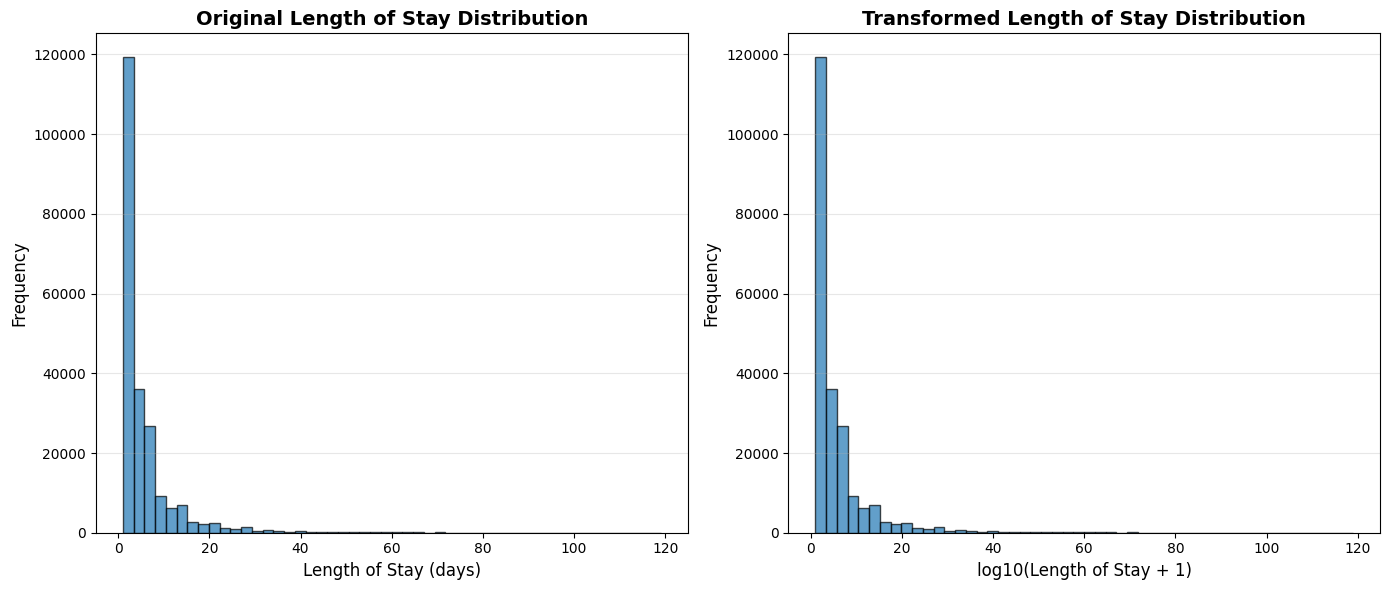

In [ ]:
# Distribution comparison of Length of Stay and Transformed Length of Stay
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original Length of Stay
axes[0].hist(df['LengthOfStay'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Length of Stay (days)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Original Length of Stay Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Transformed Length of Stay
axes[1].hist(df['Transformed_LengthOfStay'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('log10(Length of Stay + 1)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Transformed Length of Stay Distribution', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1487
[LightGBM] [Info] Number of data points in the train set: 175552, number of used features: 29
[LightGBM] [Info] Start training from score 5.666509
Evaluation Metrics (Using None transformation):
R²: 0.4811104960678241
RMSE: 5.824601357974093


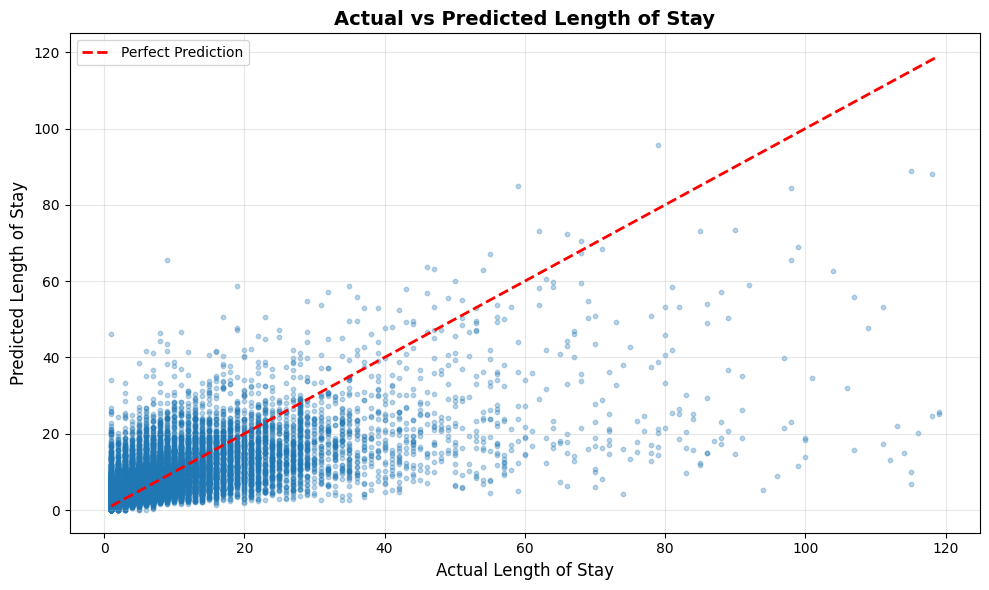

Correlation between Actual and Predicted Length of Stay: 0.6936959922284978


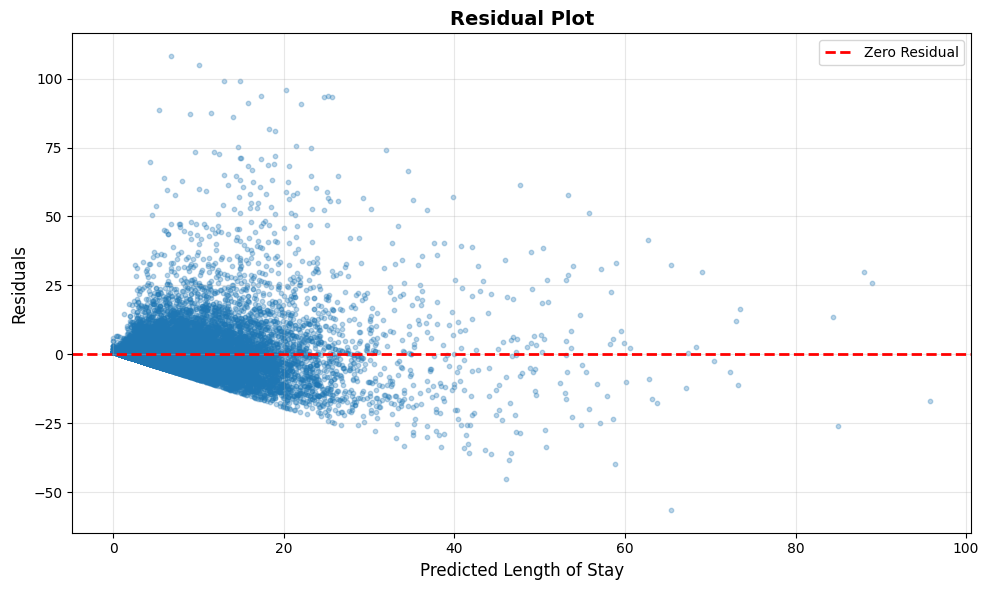

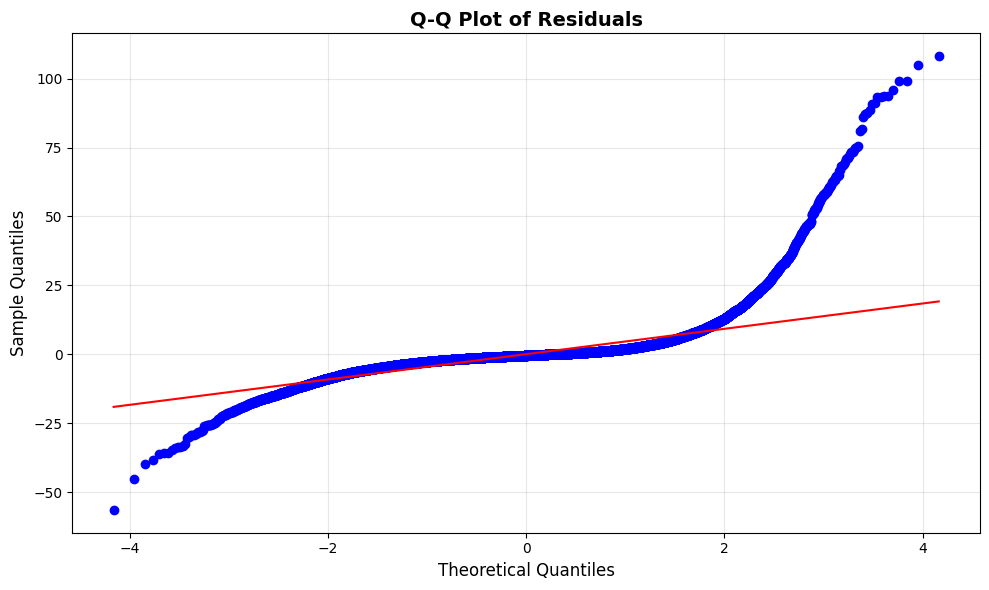

In [ ]:
y_raw = df["LengthOfStay"]
y_trans = df["Transformed_LengthOfStay"]
X = df.drop(columns=["LengthOfStay", "Transformed_LengthOfStay"])

X_train, X_test, yraw_train, yraw_test, ytrans_train, ytrans_test = train_test_split(
    X, y_raw, y_trans, train_size=TRAIN_SIZE, random_state=SEED
)

model = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=SEED)

y_train = ytrans_train if with_transformed_los else yraw_train
model.fit(X_train, y_train)

pred = model.predict(X_test)
y_pred = backtransf_function(pred) if with_transformed_los else pred
y_pred = np.maximum(y_pred, 0)  # LOS can't be negative

print(f"Evaluation Metrics (Using {desired_transformation} transformation):")
print("R²:", r2_score(yraw_test, y_pred))
print("RMSE:", root_mean_squared_error(yraw_test, y_pred))


plt.figure(figsize=(10, 6))
plt.scatter(yraw_test, y_pred, alpha=0.3, s=10)
plt.plot([yraw_test.min(), yraw_test.max()], [yraw_test.min(), yraw_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Length of Stay', fontsize=12)
plt.ylabel('Predicted Length of Stay', fontsize=12)
plt.title('Actual vs Predicted Length of Stay', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation between Actual and Predicted Length of Stay
correlation = np.corrcoef(yraw_test, y_pred)[0, 1]
print("Correlation between Actual and Predicted Length of Stay:", correlation)


residuals = yraw_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3, s=10)
plt.axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Residual')
plt.xlabel('Predicted Length of Stay', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals', fontsize=14, fontweight='bold')
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()